1. Pituitary Tumor
    - Pituitary tumors arise from the pituitary gland, a small gland located at the base of the brain. This gland plays a vital role in regulating hormones that control various body functions, such as growth, metabolism, and reproduction.
2. Meningioma Tumor
    - Meningiomas develop from the meninges, the membranes that surround the brain and spinal cord. Although these tumors arise outside the brain tissue, they can press against the brain as they grow.
3. Glioma Tumor
    - Gliomas are tumors that originate in the glial cells, which provide support and protection for neurons in the brain and spinal cord. This is a broad category that includes several types of tumors, each with different behaviors and prognoses
4. Normal
    - This class refers to images with no signs of tumor growth or abnormalities. The brain is structurally normal with no lesions or abnormal masses.
    
    
- Key Differences Between Tumor Types:
    - Origin: Each tumor type originates from different tissues:
    - Pituitary tumors arise from the pituitary gland.
    - Meningiomas originate in the meninges.
    - Gliomas develop from glial cells.
    
- Behavior:
    - Pituitary tumors and meningiomas are generally benign, but their location near critical brain structures can cause serious symptoms.
    - Gliomas, especially glioblastomas, tend to be more aggressive and malignant.

In [1]:
from PIL import Image
import os
import shutil
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, AveragePooling2D,
                                     BatchNormalization, Flatten, Dense, Dropout)
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import warnings

In [2]:
warnings.filterwarnings("ignore")

# Utilities Functions

In [67]:
# Function to plot loss, accuracy and best epoch
def learning_curves_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

In [4]:
def train_val_test_data(batch_size, img_size, train_directory, validation_directory, test_directory):

    train_dataset = tf.keras.utils.image_dataset_from_directory(train_directory,
                                                                shuffle=True,
                                                                batch_size=batch_size,
                                                                image_size=img_size,
                                                                seed=42)

    validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_directory,
                                                                     shuffle=False,
                                                                     batch_size=batch_size,
                                                                     image_size=img_size,
                                                                     seed=42)

    test_dataset = tf.keras.utils.image_dataset_from_directory(test_directory,
                                                               batch_size=batch_size,
                                                               image_size=img_size,
                                                               shuffle=False,
                                                               seed=42)

    class_names = train_dataset.class_names
    return train_dataset, validation_dataset, test_dataset, class_names

In [5]:
# Function to load image using URL and plot with predicted class
def load_prep(img_path, img_title):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_image(image)
    image = tf.image.resize(image,size=(224,224))

    plt.imshow(image / 255.)
    plt.title(img_title)
    plt.suptitle(image.shape)

In [6]:
def show_samples(data_dir, class_names, num_samples=3):
    """
    Display a random sample of images from each class.
    
    Parameters:
    - data_dir: The base directory containing subfolders for each class.
    - class_names: List of class names (subfolders in the data_dir).
    - num_samples: Number of random samples to display from each class.
    """
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(num_samples * 3, len(class_names) * 3))
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        images = os.listdir(class_path)
        
        # Randomly select images from the class folder
        selected_images = random.sample(images, num_samples)
        
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')  # Hide axis
            
            # Set the title above each image
            axes[i, j].set_title(class_name, fontsize=10, pad=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def learning_curves_tuning(tr_data, start_epoch, history_fine=None, fine_tune_epoch=None):
    # Get training and validation data from initial training
    tacc = tr_data.history['accuracy'][:]
    tloss = tr_data.history['loss'][:]
    vacc = tr_data.history['val_accuracy'][:]
    vloss = tr_data.history['val_loss'][:]

    # Ensure the lengths of training data and epochs match
    train_epochs_count = len(tacc) + start_epoch  # or len(vloss), should be the same
    train_epochs = list(range(1, train_epochs_count + 1))

    # If fine-tuning data exists, concatenate it
    if history_fine:
        tacc += history_fine.history['accuracy']
        tloss += history_fine.history['loss']
        vacc += history_fine.history['val_accuracy']
        vloss += history_fine.history['val_loss']

    # Ensure the total epoch count matches the combined data
    total_epochs_count = len(tacc)  # Now the length should match tloss or vloss
    total_epochs = list(range(1, total_epochs_count + 1))

    # Find best epoch based on validation loss and accuracy
    index_loss = np.argmin(vloss)  # epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)  # epoch with the highest validation accuracy
    acc_highest = vacc[index_acc]

    # Define plot labels
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    # Plot loss curves
    axes[0].plot(total_epochs, tloss, 'r', label='Training Loss')
    axes[0].plot(total_epochs, vloss, 'g', label='Validation Loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    
    # Add fine-tuning marker
    if fine_tune_epoch:
        axes[0].axvline(x=fine_tune_epoch, color='orange', linestyle='--', label='Start Fine Tuning')

    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Plot accuracy curves
    axes[1].plot(total_epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(total_epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    
    # Add fine-tuning marker
    if fine_tune_epoch:
        axes[1].axvline(x=fine_tune_epoch, color='orange', linestyle='--', label='Start Fine Tuning')

    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Data Loading & Preprocessing

In [7]:
data_dir = "/kaggle/input/brain-tumors-256x256/Data"

In [8]:
class_names = [class_name for class_name in os.listdir(data_dir)]
class_names

['pituitary_tumor', 'meningioma_tumor', 'glioma_tumor', 'normal']

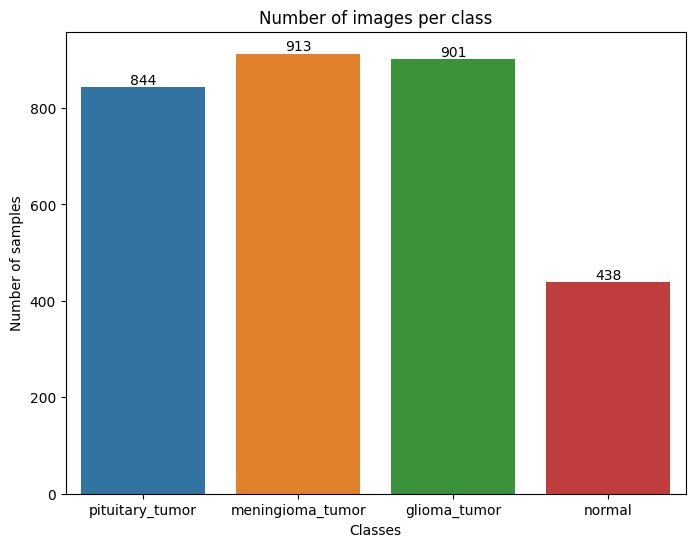

In [9]:
counts = [] 
# Loop over classes to iterate below code for each class
for class_name in class_names :
    # Define class path by joining base_directory and class_name
    class_path = os.path.join(data_dir, class_name)
    counts.append(len(os.listdir(class_path)))

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=class_names, y=counts)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{counts[i]}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10)

plt.title('Number of images per class')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.show()

In [10]:
# Create new directories for train, validation, and test splits
output_dirs = {
    'train': '/kaggle/working/train',
    'val': '/kaggle/working/val',
    'test': '/kaggle/working/test'
}

# Make sure the directories exist
for split in output_dirs.values():
    os.makedirs(split, exist_ok=True)
    for class_name in class_names:
        os.makedirs(os.path.join(split, class_name), exist_ok=True)

# Loop through each class folder and collect image paths
image_paths = []
image_labels = []
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, img_name))
        image_labels.append(class_name)

# Split data into train (80%), val+test (20%)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, image_labels, test_size=0.1, stratify=image_labels, random_state=42
)

# Further split val_test into validation (10%) and test (10%)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.11, stratify=train_val_labels, random_state=42
)

# Function to move files to their corresponding directories
def move_files(file_paths, file_labels, split):
    for img_path, label in zip(file_paths, file_labels):
        dest_folder = os.path.join(output_dirs[split], label)
        shutil.copy(img_path, dest_folder)  # Use shutil.move if you want to move instead of copy

# Move images to train, validation, and test folders
move_files(train_paths, train_labels, 'train')
move_files(val_paths, val_labels, 'val')
move_files(test_paths, test_labels, 'test')

print("Dataset split completed!")

Dataset split completed!


In [193]:
train_dir = "/kaggle/working/train"
val_dir = "/kaggle/working/val"
test_dir = "/kaggle/working/test"

batch_size=16
image_shape = (224, 224)

train, val, test, class_names = train_val_test_data(batch_size, image_shape, train_dir, val_dir, test_dir)

Found 2479 files belonging to 4 classes.
Found 307 files belonging to 4 classes.
Found 310 files belonging to 4 classes.


In [194]:
def count_images_in_directory(directory):
    """Count the number of images in each class within a given directory."""
    counts = {}
    # Loop over classes (subdirectories)
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Ensure it's a directory
            counts[class_name] = len(os.listdir(class_path))  # Count files
    return counts

# Count images for each split
train_counts = count_images_in_directory(train_dir)
val_counts = count_images_in_directory(val_dir)
test_counts = count_images_in_directory(test_dir)

# Print the counts
print("Training Set Counts:")
print(train_counts)
print("\nValidation Set Counts:")
print(val_counts)
print("\nTest Set Counts:")
print(test_counts)

Training Set Counts:
{'glioma_tumor': 722, 'normal': 351, 'meningioma_tumor': 731, 'pituitary_tumor': 675}

Validation Set Counts:
{'glioma_tumor': 89, 'normal': 43, 'meningioma_tumor': 91, 'pituitary_tumor': 84}

Test Set Counts:
{'glioma_tumor': 90, 'normal': 44, 'meningioma_tumor': 91, 'pituitary_tumor': 85}


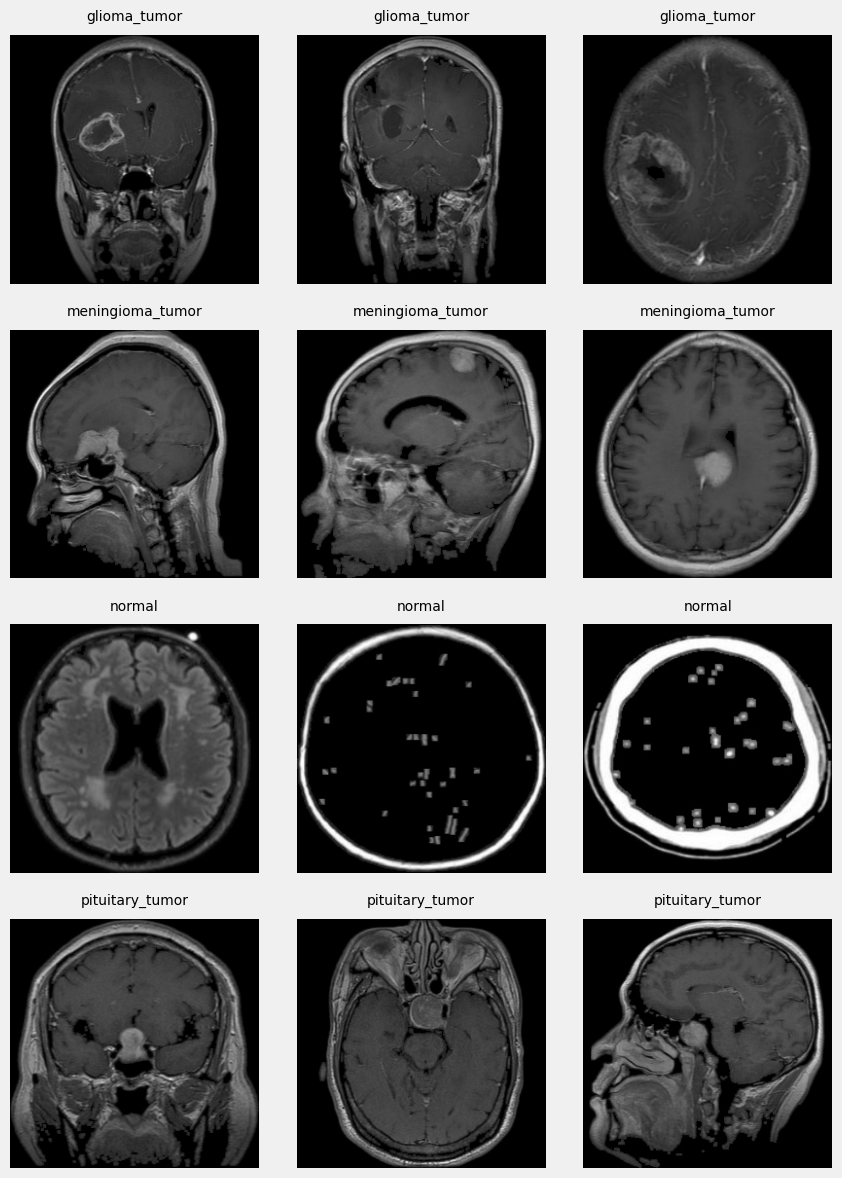

In [195]:
# Show 3 random samples from each class
show_samples(train_dir, class_names, num_samples=3)

# CNN Model

In [219]:
# Define ImageDataGenerators with augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0,1]
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test generators should not have augmentation, just rescaling
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode="grayscale",
    target_size=image_shape,
    batch_size=batch_size,
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    color_mode="grayscale",
    target_size=image_shape,
    batch_size=batch_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    color_mode="grayscale",
    target_size=image_shape,
    batch_size=batch_size,
    shuffle=False
)

Found 2479 images belonging to 4 classes.
Found 307 images belonging to 4 classes.
Found 310 images belonging to 4 classes.


In [220]:
# input_shape = (224, 224, 3) # RGB
input_shape = (224, 224, 1) # Gray Scale 
num_classes = 4

In [221]:
# model = Sequential()

# model.add(Conv2D(64, (3, 3), activation='relu',padding="same", input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu',padding="same"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
# model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(128, (5, 5), activation='relu', padding="same"))
# model.add(Conv2D(128, (5, 5), activation='relu', padding="same"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

# # model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
# # model.add(BatchNormalization())

# # Fully connected layers
# model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

In [222]:
model = Sequential()

model.add(Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (5, 5), activation='relu', padding="same"))
model.add(Conv2D(64, (5, 5), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (5, 5), activation='relu', padding="same"))
model.add(Conv2D(64, (5, 5), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (5, 5), activation='relu', padding="same"))
model.add(Conv2D(32, (5, 5), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

In [223]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [224]:
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 222, 222, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 222, 222, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 222, 222, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 111, 111, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 111, 111, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 111, 111, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 55, 55, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 55, 55, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 55, 55, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 55, 55, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 27, 27, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 27, 27, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 27, 27, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 13, 13, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 13, 13, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 13, 13, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,364,420 (5.20 MB)

 Trainable params: 1,363,076 (5.20 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [215]:
# plot_model(model, show_shapes=True, show_layer_names=True)

In [225]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=4,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              verbose=1,
                              patience=2,
                              min_lr=1e-10)

model_checkpoint = ModelCheckpoint('model.keras',
                                   monitor='val_loss',
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [226]:
history = model.fit(
    train_generator,
    epochs=35,
    validation_data=validation_generator,
    callbacks=callbacks,
    batch_size=batch_size,
)

Epoch 1/35
155/155 ━━━━━━━━━━━━━━━━━━━━ 61s 264ms/step - accuracy: 0.4331 - loss: 1.4412 - val_accuracy: 0.2899 - val_loss: 4.3648 - learning_rate: 0.0010
Epoch 2/35
155/155 ━━━━━━━━━━━━━━━━━━━━ 35s 223ms/step - accuracy: 0.6032 - loss: 0.9657 - val_accuracy: 0.4691 - val_loss: 1.7765 - learning_rate: 0.0010
Epoch 3/35
155/155 ━━━━━━━━━━━━━━━━━━━━ 35s 227ms/step - accuracy: 0.6684 - loss: 0.8193 - val_accuracy: 0.5700 - val_loss: 1.1249 - learning_rate: 0.0010
Epoch 4/35
155/155 ━━━━━━━━━━━━━━━━━━━━ 35s 226ms/step - accuracy: 0.7209 - loss: 0.7097 - val_accuracy: 0.6417 - val_loss: 1.2888 - learning_rate: 0.0010
Epoch 5/35
155/155 ━━━━━━━━━━━━━━━━━━━━ 35s 225ms/step - accuracy: 0.7471 - loss: 0.6568 - val_accuracy: 0.7199 - val_loss: 0.7687 - learning_rate: 0.0010
Epoch 6/35
155/155 ━━━━━━━━━━━━━━━━━━━━ 35s 226ms/step - accuracy: 0.8072 - loss: 0.5025 - val_accuracy: 0.6938 - val_loss: 0.6797 - learning_rate: 0.0010
Epoch 7/35
155/155 ━━━━━━━━━━━━━━━━━━━━ 35s 226ms/step - accuracy: 0.8

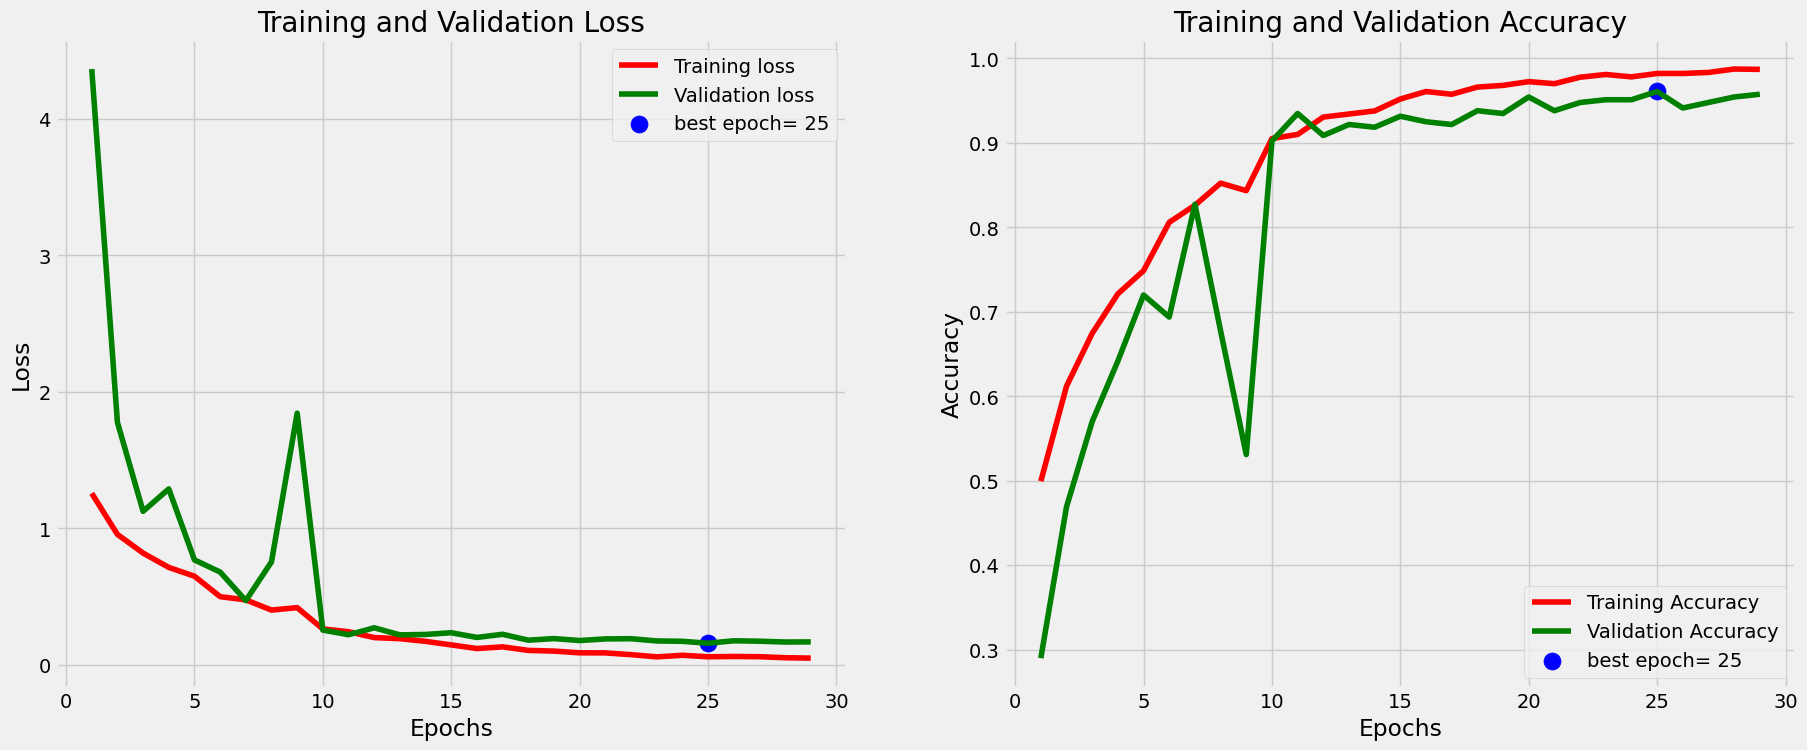

In [227]:
learning_curves_plot(history, start_epoch=0)

In [228]:
model = load_model("/kaggle/working/model.keras")

In [229]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"test loss: {test_loss}")
print(f"test accuracy: {test_acc}")

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8957 - loss: 0.3521
test loss: 0.2932557761669159
test accuracy: 0.9225806593894958
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


In [230]:
# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.88      0.91        90
meningioma_tumor       0.90      0.88      0.89        91
          normal       0.96      1.00      0.98        44
 pituitary_tumor       0.90      0.98      0.94        85

        accuracy                           0.92       310
       macro avg       0.93      0.93      0.93       310
    weighted avg       0.92      0.92      0.92       310



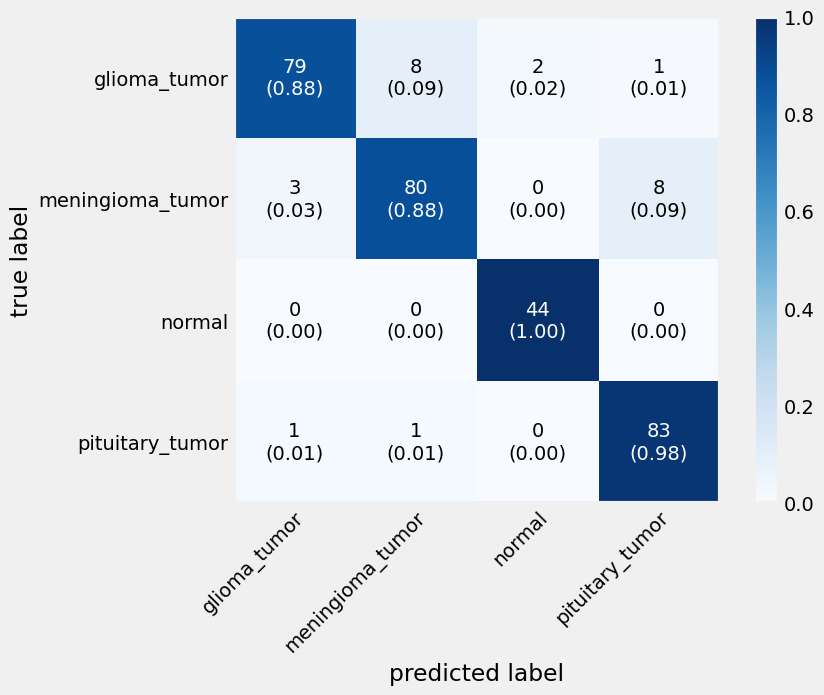

In [231]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plot_confusion_matrix(conf_matrix, 
                      class_names=class_names, 
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.show();

# NasNetMobile & EfficientNetB2/3

In [170]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory("/kaggle/working/train",
                                             batch_size=8,
                                             image_size=(224, 224))

validation_dataset = image_dataset_from_directory("/kaggle/working/val",
                                             batch_size=8,
                                             image_size=(224, 224))

test_dataset = image_dataset_from_directory("/kaggle/working/test",
                                             batch_size=8,
                                             image_size=(224, 224))

Found 2479 files belonging to 4 classes.
Found 307 files belonging to 4 classes.
Found 310 files belonging to 4 classes.


In [171]:
class_names = train_dataset.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

In [172]:
from tensorflow.keras.layers import (RandomFlip, RandomRotation, Rescaling,
                        RandomZoom, Resizing, RandomBrightness, RandomContrast)

def data_augmenter():
    '''
    Create a Sequential model composed of multiple layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal", seed=42)),
    data_augmentation.add(RandomRotation(0.1, seed=42, fill_mode="nearest")),
    data_augmentation.add(RandomBrightness(0.1, seed=42)),
    data_augmentation.add(RandomContrast(0.1, seed=42)),
    data_augmentation.add(RandomZoom(0.1, fill_mode="nearest", seed=42)),

    return data_augmentation

In [173]:
preprocess_input = tf.keras.applications.nasnet.preprocess_input

In [174]:
def nasnet_model(data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for multiclass classification out of the NasNetMobile model
    Arguments:
    Returns:
        tf.keras.model
    '''

    base_model = tf.keras.applications.NASNetMobile(input_shape=(224,224,3),
                                                        include_top= False, # <== Important!!!!
                                                        weights='imagenet') # From imageNet

    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv3Large input size)
    inputs = tf.keras.Input(shape=(224, 224, 3))
    
    x = data_augmenter()(inputs)
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)

    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False)

    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.4)(x)

    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = Dense(4, activation = 'softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

In [175]:
nasnet = nasnet_model(data_augmenter())

In [176]:
# Compile the model
nasnet.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
nasnet.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_21 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_6 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_6 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ NASNet (Functional)             │ (None, 7, 7, 1056)     │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1056)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1056)           │         4,224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       135,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,409,752 (16.82 MB)

 Trainable params: 137,924 (538.77 KB)

 Non-trainable params: 4,271,828 (16.30 MB)

In [177]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=8,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.3,
                              verbose=1,
                              patience=2,
                              min_lr=1e-10)

model_checkpoint = ModelCheckpoint('nasnet_model.keras',
                                   monitor='val_loss',
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [178]:
# Train the model
nasnet_history = nasnet.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15,
    callbacks=callbacks,
    batch_size=8
)

Epoch 1/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - accuracy: 0.5181 - loss: 1.3505 - val_accuracy: 0.7883 - val_loss: 0.6114 - learning_rate: 0.0010
Epoch 2/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.7012 - loss: 0.8284 - val_accuracy: 0.7915 - val_loss: 0.6014 - learning_rate: 0.0010
Epoch 3/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.7351 - loss: 0.7038 - val_accuracy: 0.8208 - val_loss: 0.4790 - learning_rate: 0.0010
Epoch 4/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.7555 - loss: 0.6569 - val_accuracy: 0.8176 - val_loss: 0.4529 - learning_rate: 0.0010
Epoch 5/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.7632 - loss: 0.6104 - val_accuracy: 0.7948 - val_loss: 0.4832 - learning_rate: 0.0010
Epoch 6/15
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7867 - loss: 0.5388
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
310/310 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.7867 - los

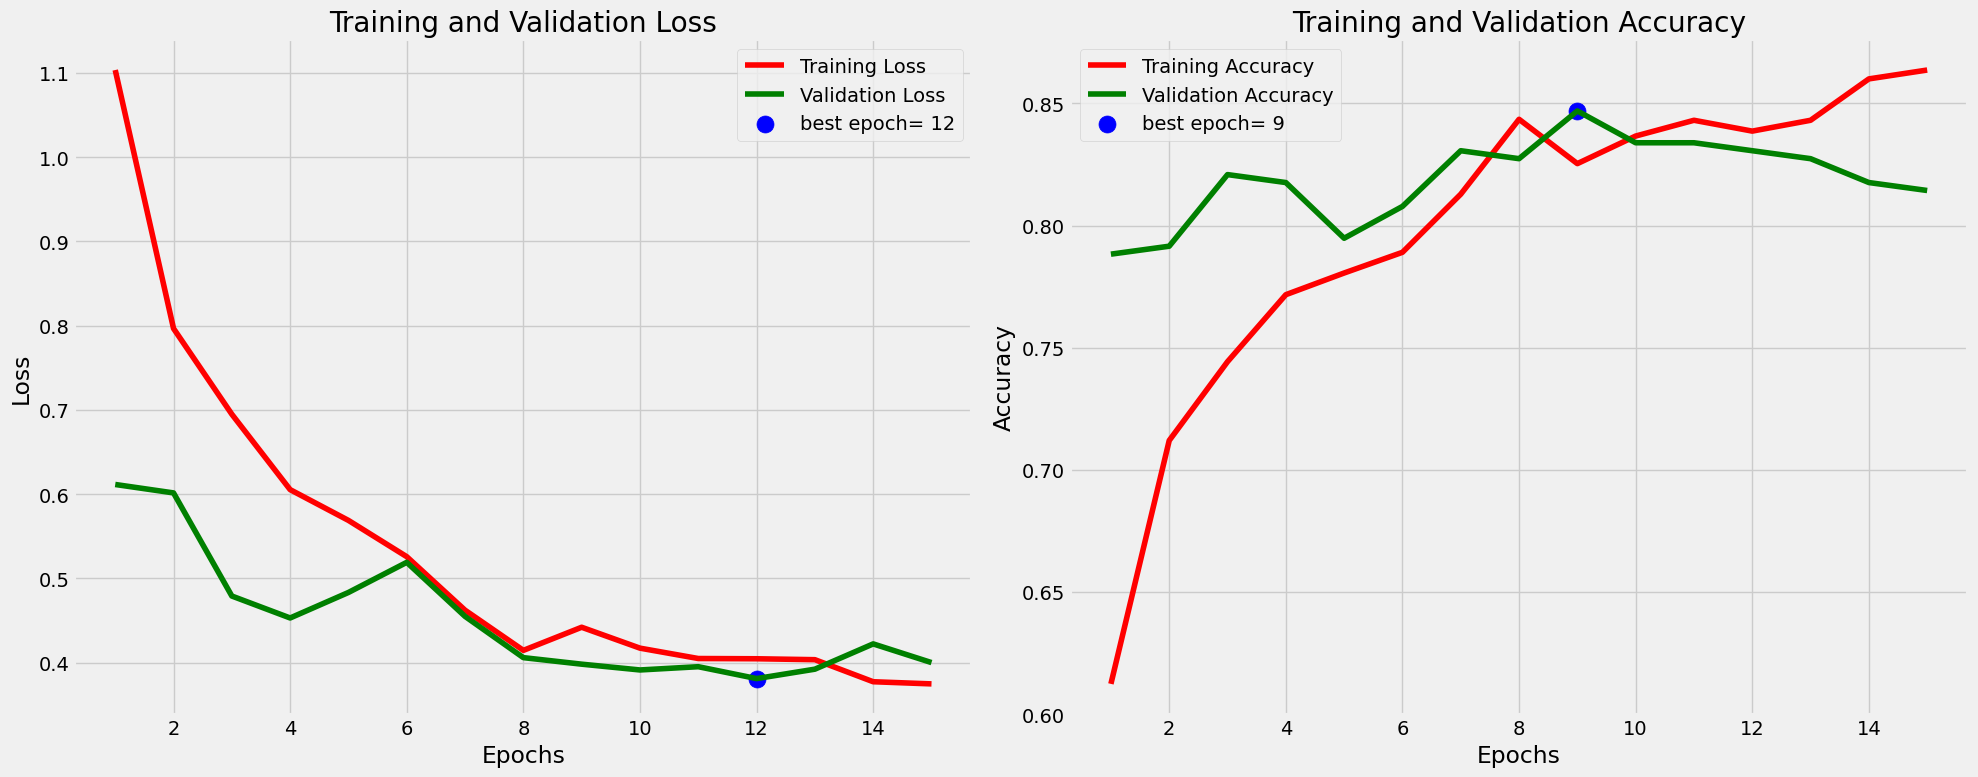

In [179]:
learning_curves_tuning(nasnet_history, start_epoch=0)

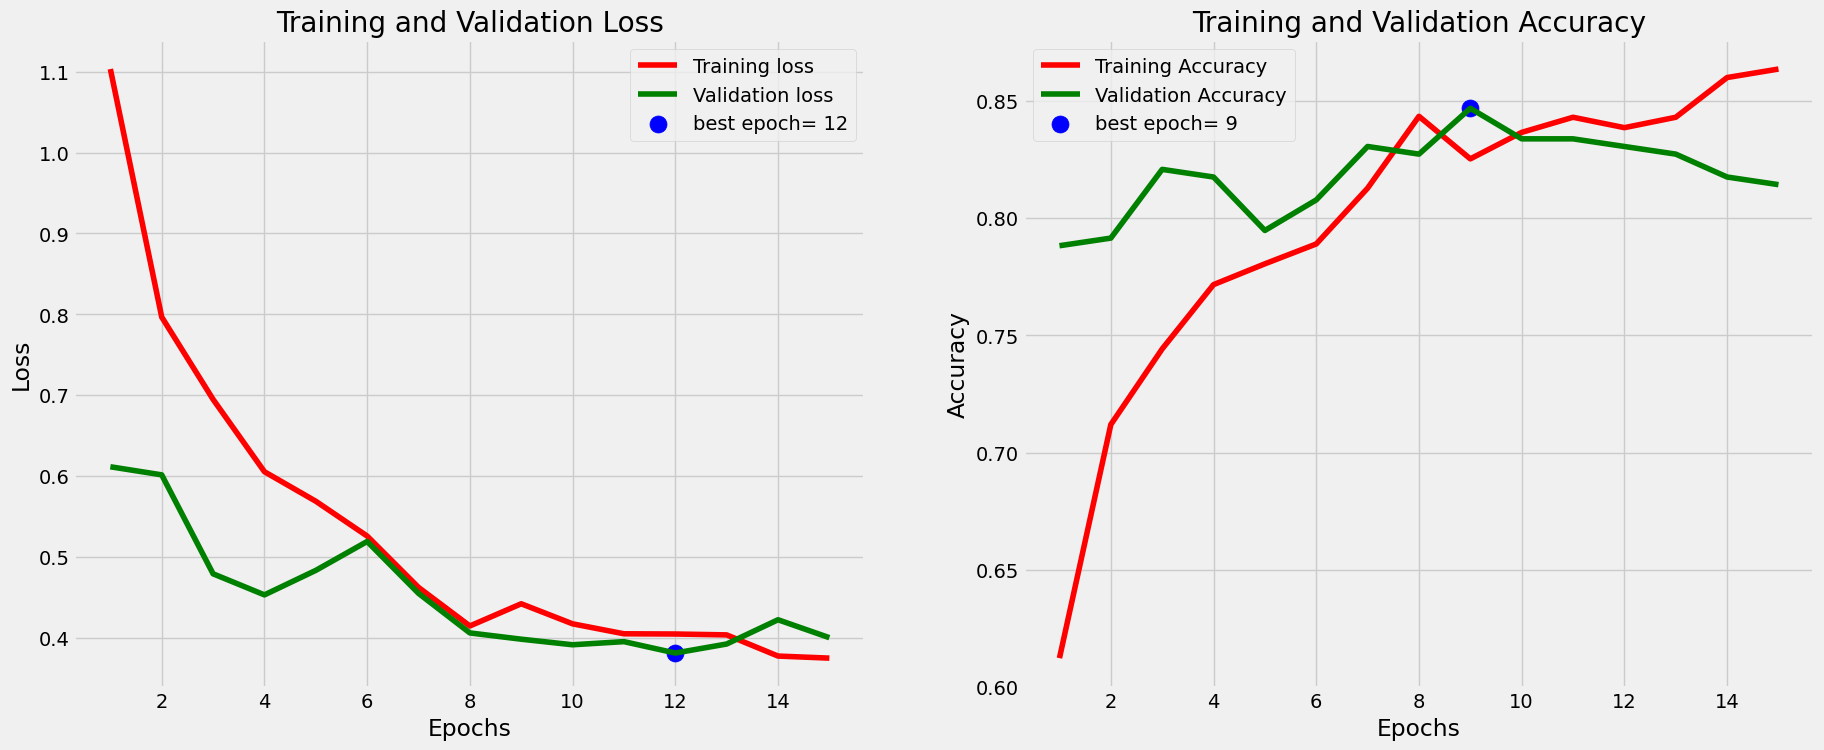

In [180]:
learning_curves_plot(nasnet_history, start_epoch=0)

In [186]:
# Fine-tuning

base_model = nasnet.layers[2]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 35

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

nasnet.compile(loss="sparse_categorical_crossentropy",
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy'])

Number of layers in the base model:  769


In [187]:
fine_tune_epochs = 25 # best from graph is 13
total_epochs =  15 + fine_tune_epochs

history_fine = nasnet.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=nasnet_history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=callbacks)

Epoch 15/40
310/310 ━━━━━━━━━━━━━━━━━━━━ 198s 249ms/step - accuracy: 0.6941 - loss: 0.8110 - val_accuracy: 0.5342 - val_loss: 2.1655 - learning_rate: 1.0000e-04
Epoch 16/40
310/310 ━━━━━━━━━━━━━━━━━━━━ 71s 229ms/step - accuracy: 0.8009 - loss: 0.5290 - val_accuracy: 0.7296 - val_loss: 0.9519 - learning_rate: 1.0000e-04
Epoch 17/40
310/310 ━━━━━━━━━━━━━━━━━━━━ 71s 228ms/step - accuracy: 0.8580 - loss: 0.3625 - val_accuracy: 0.8274 - val_loss: 0.4593 - learning_rate: 1.0000e-04
Epoch 18/40
310/310 ━━━━━━━━━━━━━━━━━━━━ 71s 228ms/step - accuracy: 0.8885 - loss: 0.3064 - val_accuracy: 0.8143 - val_loss: 0.4808 - learning_rate: 1.0000e-04
Epoch 19/40
310/310 ━━━━━━━━━━━━━━━━━━━━ 75s 241ms/step - accuracy: 0.9165 - loss: 0.2699 - val_accuracy: 0.8730 - val_loss: 0.3696 - learning_rate: 1.0000e-04
Epoch 20/40
310/310 ━━━━━━━━━━━━━━━━━━━━ 72s 231ms/step - accuracy: 0.9243 - loss: 0.2210 - val_accuracy: 0.8502 - val_loss: 0.5167 - learning_rate: 1.0000e-04
Epoch 21/40
310/310 ━━━━━━━━━━━━━━━━━━━

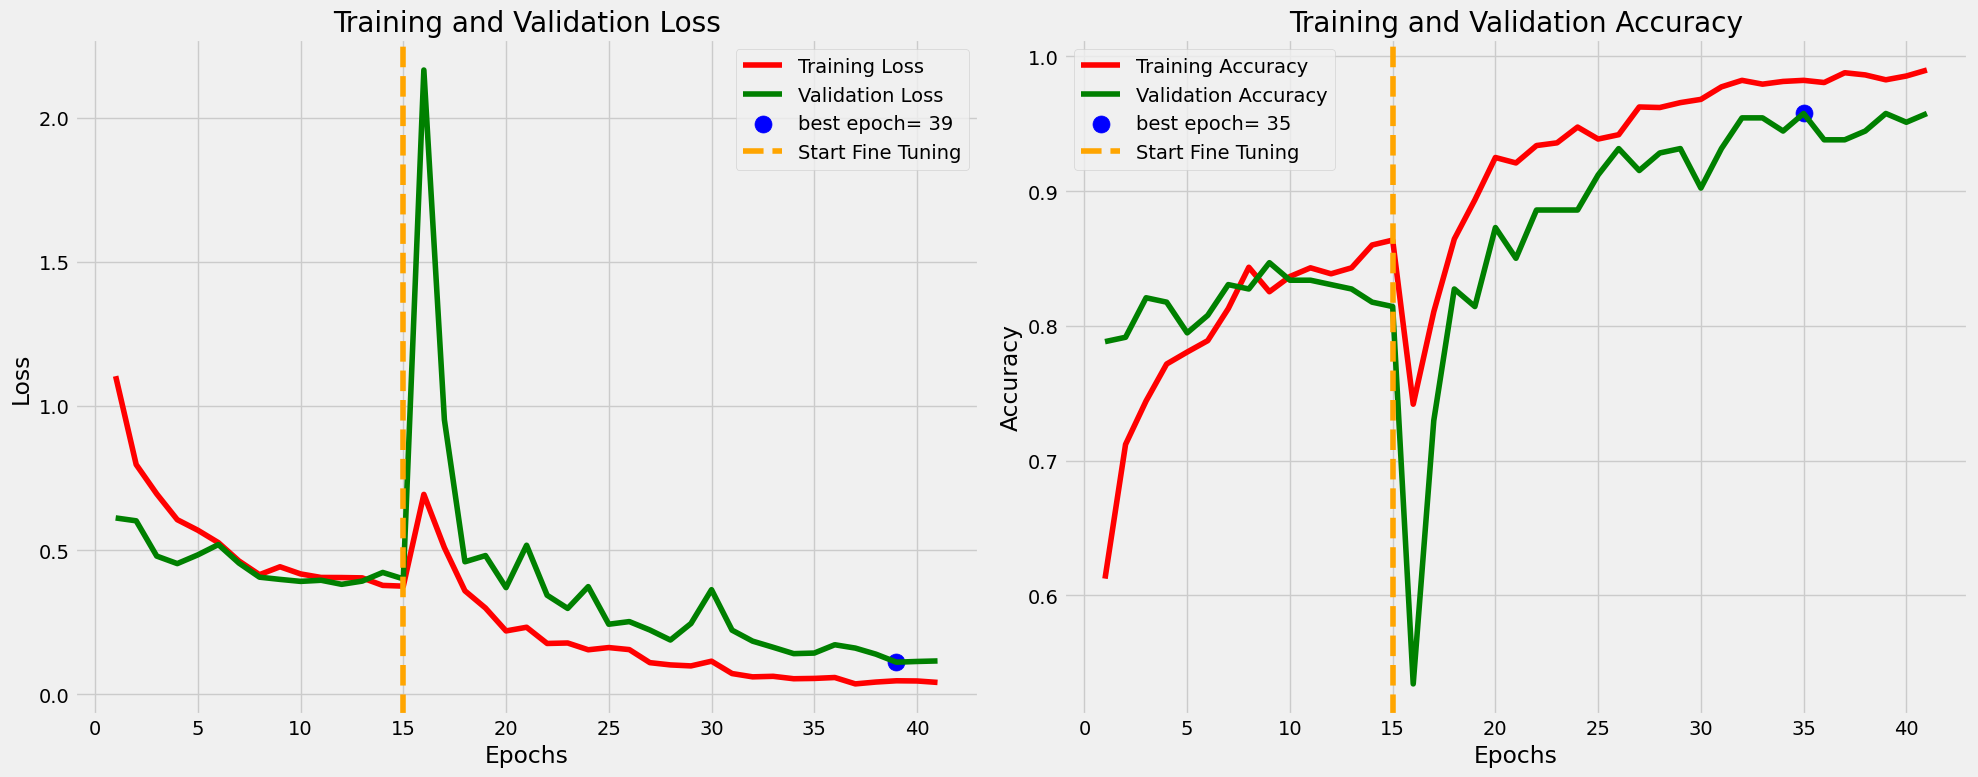

In [188]:
learning_curves_tuning(nasnet_history, start_epoch=0, history_fine=history_fine, fine_tune_epoch=15)

In [189]:
# Evaluate on test data
test_loss, test_acc = nasnet.evaluate(test_dataset)
print(f"test loss: {test_loss}")
print(f"test accuracy: {test_acc}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9663 - loss: 0.1860
test loss: 0.23736712336540222
test accuracy: 0.9516128897666931


In [190]:
# Get predictions for the entire test dataset
predicted_labels = []
true_labels = []

for images, labels in test_dataset:
    predictions = nasnet.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels)

# Convert true labels to numpy array
true_labels = np.array(true_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━

In [191]:
# Classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.91      0.94        90
meningioma_tumor       0.94      0.96      0.95        91
          normal       0.93      0.98      0.96        44
 pituitary_tumor       0.97      0.98      0.97        85

        accuracy                           0.95       310
       macro avg       0.95      0.96      0.95       310
    weighted avg       0.95      0.95      0.95       310



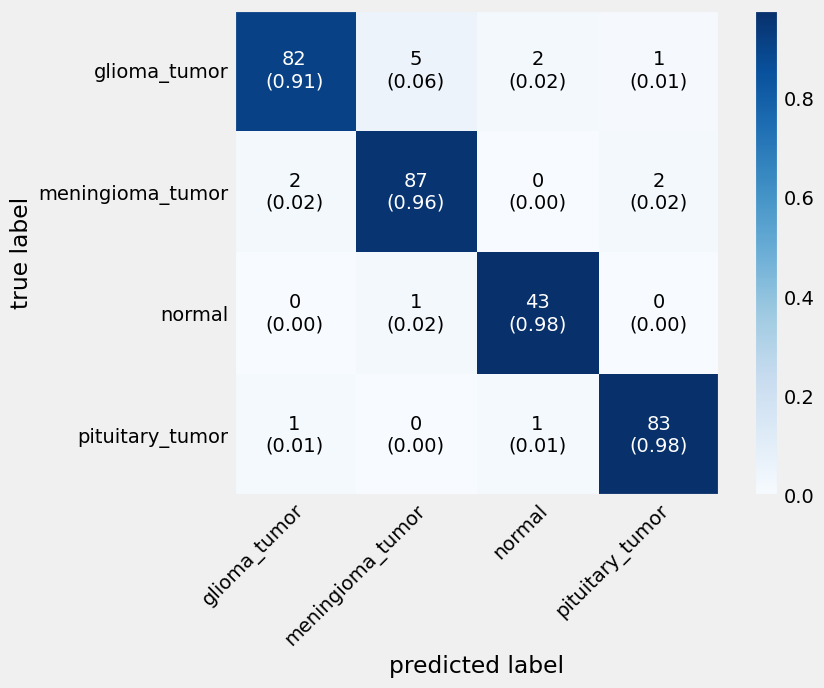

In [192]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plot_confusion_matrix(conf_matrix, 
                      class_names=class_names, 
                      show_normed=True,
                      figsize=(8,6),
                      colorbar=True)

plt.show();

# ResNet50/50V2

# Thank you